## Decision Trees, Random Forest: Predicting Bike Rentals

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll work with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the University of California, Irvine's [website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In this project, you'll try to predict the total number of bikes people rented in a given hour. We'll predict the cnt column using all of the other columns, except for casual and registered. 

### 1. Exploring the data set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


We have 17 columns in the data set without any missing values. All of the colunms except Date have the proper data type. 

In [3]:
bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The histogram of total bike rentals is right skewed.

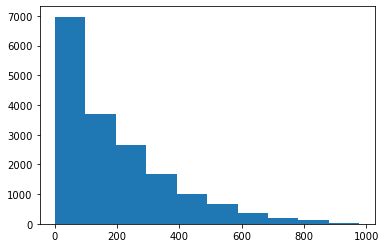

In [4]:
plt.hist(bike_rentals['cnt'])
plt.show()

We will remove the 'instant', 'casual', 'registered' and 'dteday' columns as they are not useful for our analysis or leak the inforamtion. The correlations of columns with total bike rentals shows that some of the features are not really correlated with it:

In [5]:
bike_rentals[['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
        'cnt']].corr()['cnt'].abs().sort_values(ascending = False)

cnt           1.000000
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

We remove the threee features with the lowest correlation: 'holiday', 'weekday', 'workingday'.

Among the remaining features, we have to detect those (if any) that strongly correlate with one or several other features and keep only one feature of each group to avoid model distortion.

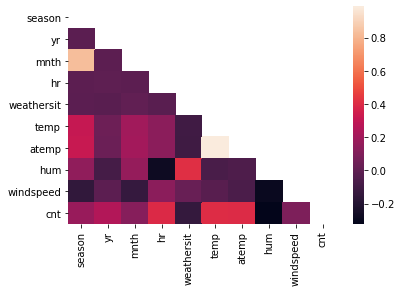

In [6]:
correlations = bike_rentals[['season', 'yr', 'mnth', 'hr', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt']].corr()
sns.heatmap(correlations, mask=np.triu(correlations))
plt.show()

The temp and atemp features are corellated. We remove the atemp as it has lower corellation with the target column.

The current features we can use for ML: ['season', 'yr', 'mnth', 'hr', 'weathersit', 'temp', 'hum', 'windspeed']

Checking the variance of the features:

In [7]:
def normalize(df):
    result = bike_rentals.copy()
    features = ['season', 'yr', 'mnth', 'hr', 'weathersit', 'temp', 'hum', 'windspeed']
    for feature_name in features:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

norm_bike_rentals = normalize(bike_rentals)
var_bike_rentals = norm_bike_rentals[['season', 'yr', 'mnth', 'hr', 'weathersit', 'temp', 'hum', 'windspeed']].var()
var_bike_rentals

season        0.136141
yr            0.250008
mnth          0.097729
hr            0.090376
weathersit    0.045420
temp          0.038607
hum           0.037222
windspeed     0.020682
dtype: float64

### 2. Feature engineering

The hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This bundles similar times together, enabling the model to make better decisions.

In [8]:
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

In [9]:
#The final list of features

features = ['season', 'yr', 'mnth', 'time_label', 'weathersit', 'temp', 'hum', 'windspeed']

### 3. Machine learning

Dataset randomization and spliting.

In [10]:
np.random.seed(1)
train = bike_rentals.sample(frac=0.8, random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

#### 3.1 Linear regression

In [11]:
lr = LinearRegression()
lr.fit(train[features], train['cnt'])
predictions = lr.predict(test[features])
mse = mean_squared_error(test['cnt'], predictions)
rmse = np.sqrt(mse)
rmse

137.66457243795756

The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

#### 3.2 Decision Tree

In [12]:
#Default settings
dt = DecisionTreeRegressor(min_samples_leaf=5)
dt.fit(train[features], train['cnt'])
predictions = dt.predict(test[features])
mse2 = mean_squared_error(test['cnt'], predictions)
rmse2 = np.sqrt(mse2)
rmse2

129.68207763458435

By taking the nonlinear predictors into account, the decision tree regressor appears to have higher accuracy than linear regression.

#### 3.3 Random Forest

In [13]:
rf = RandomForestRegressor(min_samples_leaf=5)
rf.fit(train[features], train['cnt'])
predictions = rf.predict(test[features])
mse3 = mean_squared_error(test['cnt'], predictions)
rmse3 = np.sqrt(mse3)
rmse3

114.43640113564884

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.

We will tune the parameters of Random Forest by using the Grid Search:

In [14]:
#We'll setup a very basic gridsearch for tuning the model:
rf = RandomForestRegressor(min_samples_leaf=5, random_state=1, n_estimators=100, max_features='auto', max_depth=None)
tuned_parameters = { 
    'n_estimators': [100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
}

clf = GridSearchCV(rf, tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
clf.fit(train[features], train['cnt'])
clf.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_features': 'sqrt', 'n_estimators': 200}

In [15]:
rf = RandomForestRegressor(min_samples_leaf=5, random_state=1, n_estimators=200, max_features='sqrt', max_depth=None)
rf.fit(train[features], train['cnt'])
predictions = rf.predict(test[features])
mse4 = mean_squared_error(test['cnt'], predictions)
rmse4 = np.sqrt(mse4)
rmse4

113.75929124939667

### Conclusions 
Linear regression model not surprisingly didn't perform well - there are too many features that impact our target values in various ways for that model to handle the data well. By taking the nonlinear predictors into account, the decision tree regressor appears to have higher accuracy than linear regression.
Random Forest Regressor delivered the best results.